In [1]:
%cd ~/research

import gc
import os
import sys
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import yaml
from scipy import signal

sys.path.append("src")
from utility.activity_loader import get_data_dirs, load_individuals
from utility.video import Capture, Writer, concat_field_with_frame
from visualize.individual import write_field as ind_write_field
from visualize.keypoint import write_frame as kps_write_frame

/raid6/home/yokoyama/research


/home/yokoyama/research/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.direction'] = 'in'  # x axis in
plt.rcParams['ytick.direction'] = 'in'  # y axis in

In [3]:
room_num = "09"
surgery_num = "001"

In [4]:
cfg_path = "config/individual.yaml"
with open(cfg_path, "r") as f:
    cfg = yaml.safe_load(f)

In [5]:
field = cv2.imread("image/field.png")

In [6]:
data_dirs = get_data_dirs(room_num, surgery_num)
print(data_dirs)

['data/09/001/01', 'data/09/001/02', 'data/09/001/03', 'data/09/001/04', 'data/09/001/05', 'data/09/001/06', 'data/09/001/07', 'data/09/001/08', 'data/09/001/09', 'data/09/001/10', 'data/09/001/11', 'data/09/001/12', 'data/09/001/13', 'data/09/001/14', 'data/09/001/15', 'data/09/001/16']


In [7]:
# 研修医がいないものを選択する
individuals = []
for data_dir in tqdm(data_dirs[8:9]):
    json_path = os.path.join(data_dir, ".json", "individual.json")
    loaded = load_individuals(json_path, cfg)
    individuals += list(loaded.values())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.16s/it]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


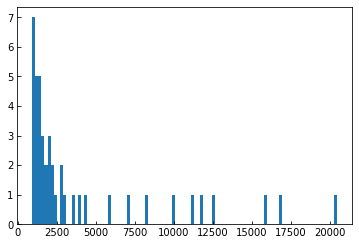

In [8]:
# histogram of length
plt.hist(
    [
        len(ind.get_indicator_all("position"))
        for ind in individuals
        if len(ind.get_indicator_all("position")) > 900
    ],
    bins=100,
)
plt.show()

In [27]:
def calc_movements(individuals, th_length=1800, th_interval=5, move_size=5400, th_norm=10, pad_type="zero"):
    movements = {}
    positions = {}
    for ind in tqdm(individuals):
        pos_dict = ind.get_indicator_all("position")

        length = max(pos_dict) - min(pos_dict)
        if length < th_length:
            continue
            
        move = []
        pos = []
        start_frame_num = pre_frame_num = list(pos_dict.keys())[0]
        for frame_num in pos_dict.keys():
            # calc diff
            pre_pos = np.array(pos_dict[pre_frame_num])
            crr_pos = np.array(pos_dict[frame_num])
            diff = crr_pos - pre_pos
            norm = np.linalg.norm(diff)
            
            if norm <= th_norm:
                frame_num_diff = frame_num - pre_frame_num
                for i in range(0, frame_num_diff - 1):
                    if pad_type == "zero":
                        # zero padding
                        move.append(0)
                        pos.append(pre_pos)
                    elif pad_type == "average":
                        # average padding
                        i += 1
                        move.append(norm / frame_num_diff * i)
                        pos.append(pre_pos + diff / frame_num_diff * i)
                move.append(norm)
                pos.append(crr_pos)

            pre_frame_num = frame_num

        movements[ind.id] = move
        positions[ind.id] = pos
    
    # crop movenemts for move_size
    ret_movements = {}
    ret_positions = {}
    for pid in tqdm(movements.keys()):
        count = 1
        for i in range(len(movements[pid]))[::move_size]:
            crop_move = movements[pid][i:i + move_size]
            crop_pos = positions[pid][i:i + move_size]
            
            # if len(crop_move) < move_size:
            #     # zero padding
            #     crop_move += np.full(move_size - len(crop_move), 0).tolist()
            #     crop_pos += [[0, 0] for _ in range(move_size - len(crop_pos))]
        
            ret_movements[f"{pid}_{count:03d}"] = crop_move
            ret_positions[f"{pid}_{count:03d}"] = crop_pos
            count += 1
        
    return ret_movements, ret_positions
    
movements, positions = calc_movements(individuals)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 2317.69it/s]


In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

In [29]:
features = {}
field_size = np.array(field.shape[1::-1])
for label in movements.keys():
    mov = movements[label]
    pos = positions[label]
    
    ave_mov = np.average(mov)
    
    bbox_mov = np.max(pos, axis=0) - np.min(pos, axis=0)
    area_mov = bbox_mov[0] * bbox_mov[1]
    
    center = field_size / 2
    dist = (pos - center)
    ave_dist = np.average(np.linalg.norm(dist, axis=0))
    
    features[label] = (ave_mov, area_mov, ave_dist)
    # features[label] = (ave_mov, area_mov)
    
columns = ["ave of movements", "area of movements", "ave of distance from center"]
# columns = ["ave of movements", "area of movements"]
    
data = np.array(list(features.values()))
# data = StandardScaler().fit_transform(data)
data = MinMaxScaler().fit_transform(data)
features = {
    list(features.keys())[i]: data[i] for i in range(len(data))
}

In [30]:
n_clusters = 2
mdl = KMeans(n_clusters=n_clusters).fit(list(features.values()))
# mdl = SpectralClustering(n_clusters=n_clusters).fit(list(features.values()))
mdl_labels = mdl.labels_

In [31]:
labels = []
for i in range(n_clusters):
    labels.append(
        np.array(list(movements.keys()))[np.where(mdl_labels==i)[0]]
    )

In [32]:
def plot_pos(positions, labels):
    plt.figure(figsize=(8, 8))
    for label, pos in positions.items():
        if label in labels:
            pos = np.array(pos).T
            plt.scatter(pos[0], pos[1], label=label)

    plt.axis("off")
    plt.imshow(field)
    plt.axis([0, field.shape[1], field.shape[0], 0])
    # plt.legend()
    # plt.savefig()  # ToDo
    plt.show()

['2950_001' '2950_002' '2950_003' '2950_004' '3080_001' '3083_001'
 '3083_002' '3079_001' '3100_001' '3109_001' '3126_001' '3126_002'
 '3131_001' '3148_001' '3154_001' '3159_001' '3161_001' '3163_001'
 '3163_002' '3163_003' '3175_001' '3177_001' '3191_001' '3193_001'
 '3200_001' '3207_001' '3209_001' '3218_001' '3218_002' '3218_003'
 '3218_004' '3225_003' '3241_001' '3249_001' '3257_001' '3264_001'
 '3274_001' '3290_002' '3292_001' '3303_001']


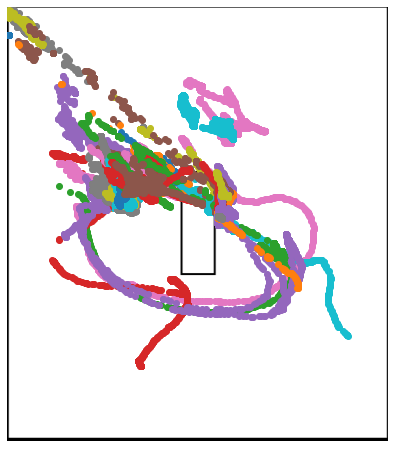

['3077_001' '3077_002' '3087_001' '3092_001' '3101_001' '3109_002'
 '3109_003' '3156_001' '3156_002' '3156_003' '3225_001' '3225_002'
 '3290_001' '3302_001']


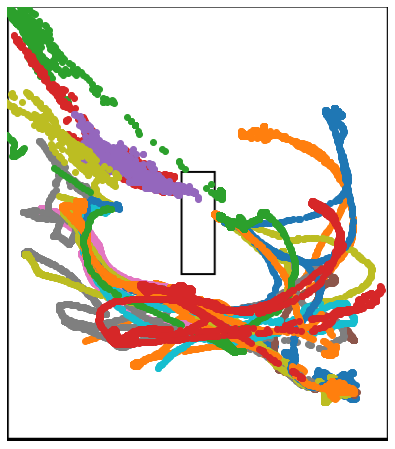

In [37]:
for i in range(n_clusters):
    print(labels[i])
    plot_pos(positions, labels[i])

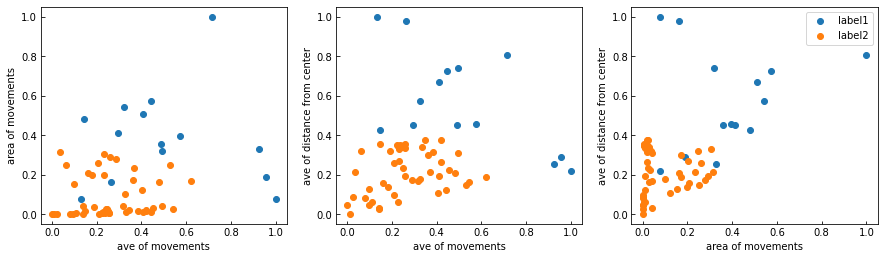

In [16]:
import itertools

comb = itertools.combinations([i for i in range(len(columns))], 2)
comb = list(comb)

fig, axs = plt.subplots(1, len(columns), figsize=(len(columns) * 5, 4))
for i in range(len(columns)):
    axs[i].set_xlabel(columns[comb[i][0]])
    axs[i].set_ylabel(columns[comb[i][1]])
    axs[i].set_xlim((-0.05, 1.05))
    axs[i].set_ylim((-0.05, 1.05))

for i in range(n_clusters):
    plt_dat = [f for l, f in features.items() if l in labels[i]]
    plt_dat = np.array(plt_dat).T
    
    for j in range(len(comb)):
        axs[j].scatter(
            plt_dat[comb[j][0]], plt_dat[comb[j][1]], label=f"label{i + 1}"
        )

plt.legend()

In [34]:
def plot_movements(movements, labels):
    for i, (label, move) in enumerate(movements.items()):
        if label in labels:
            print(label)
            plt.figure(figsize=(20, 2))
            plt.plot(move)
            plt.ylim((-0.05, 10))
            plt.show()

2950_001


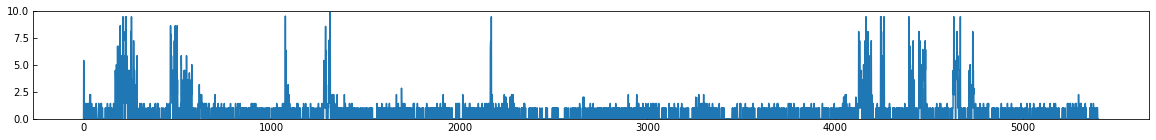

2950_002


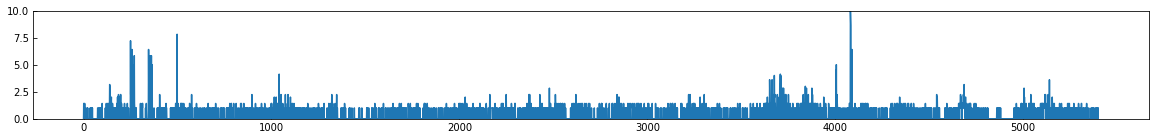

2950_003


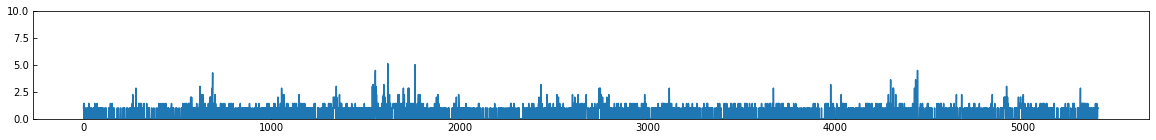

2950_004


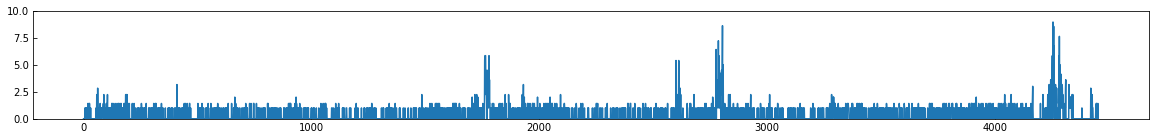

3080_001


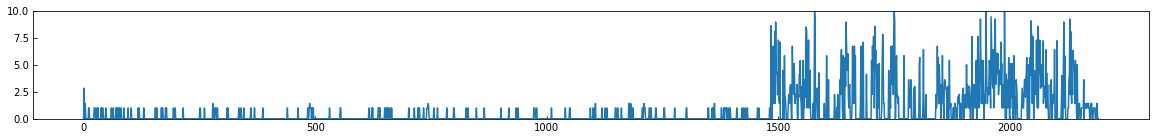

3083_001


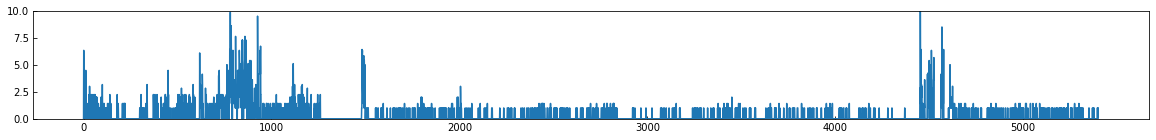

3083_002


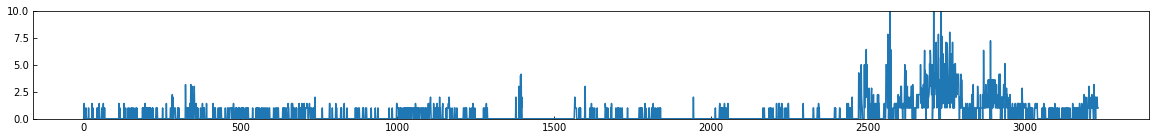

3079_001


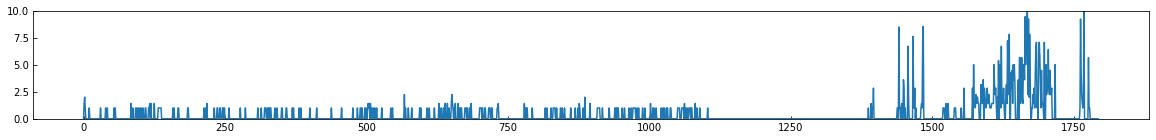

3100_001


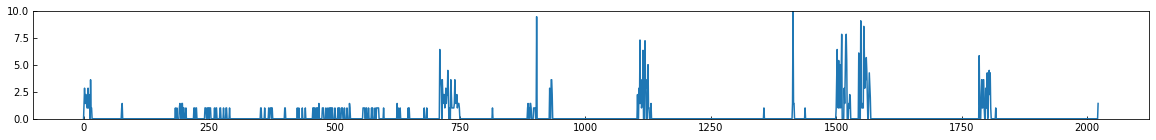

3109_001


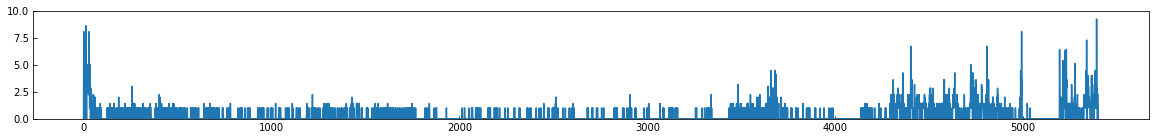

3126_001


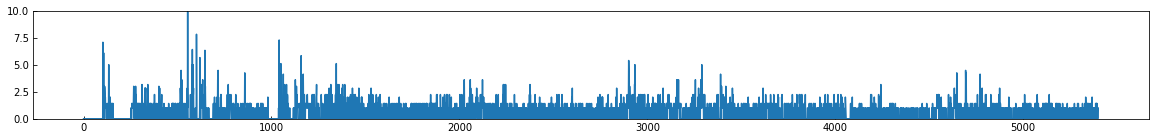

3126_002


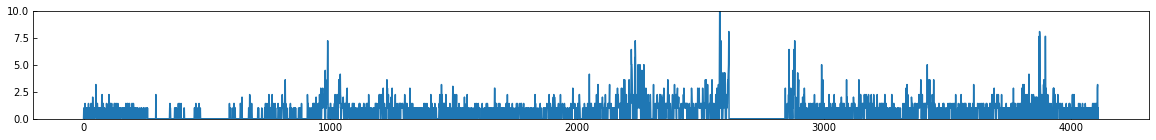

3131_001


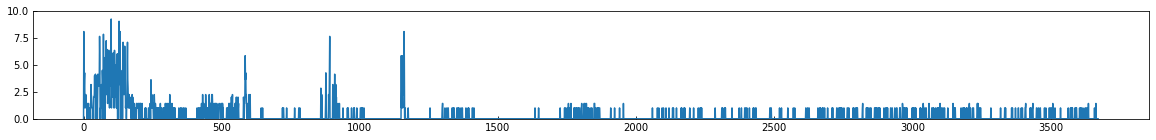

3148_001


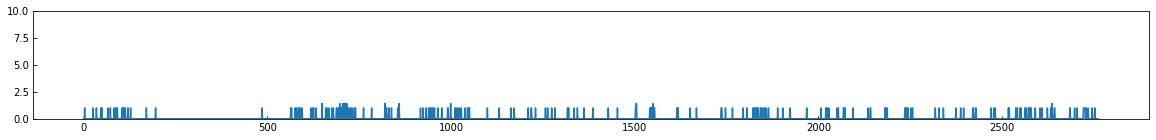

3154_001


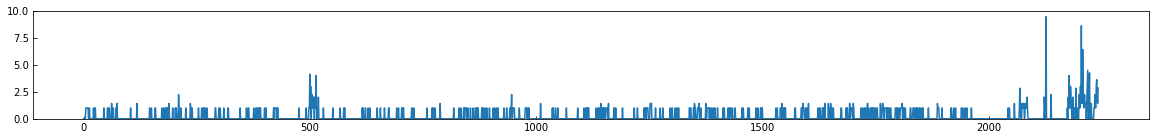

3159_001


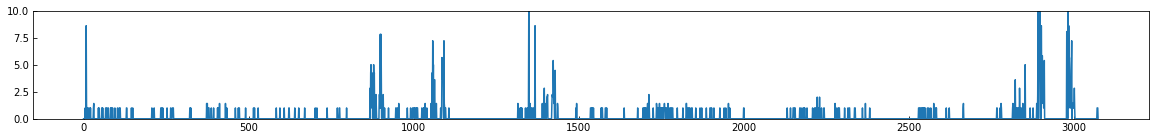

3161_001


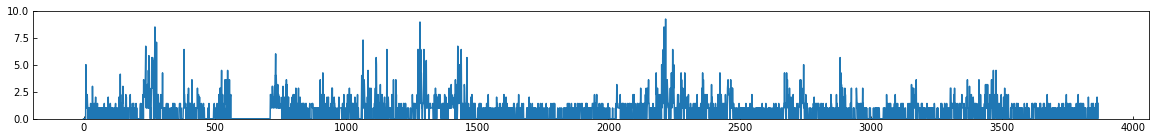

3163_001


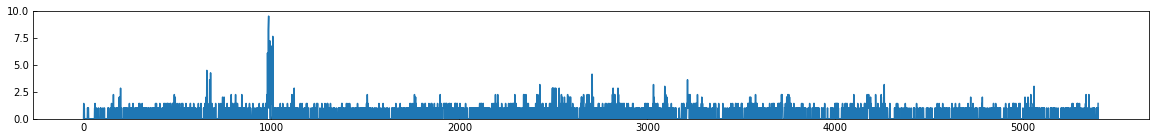

3163_002


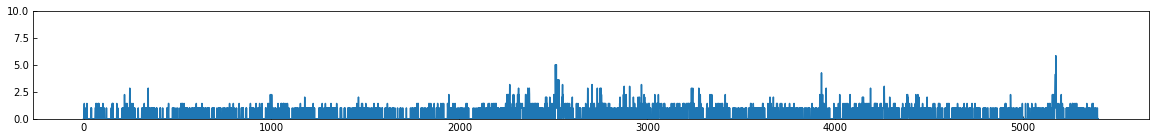

3163_003


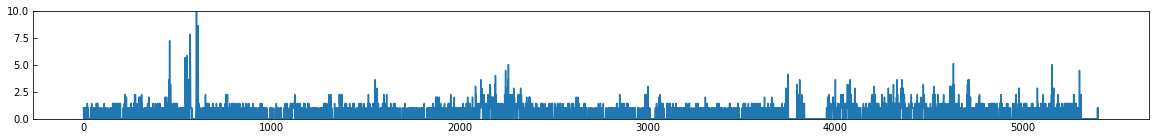

3175_001


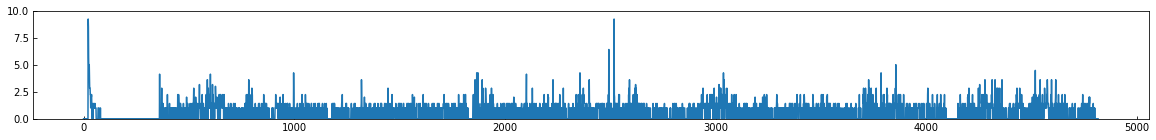

3177_001


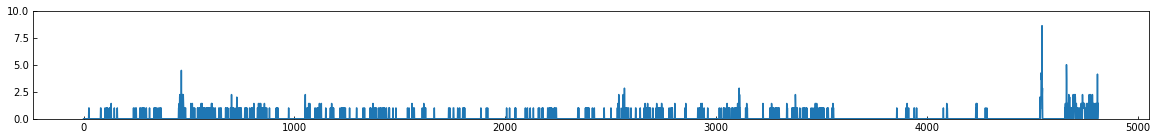

3191_001


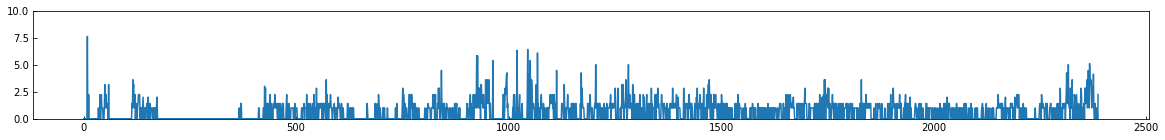

3193_001


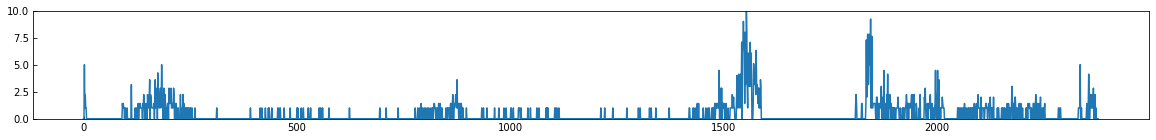

3200_001


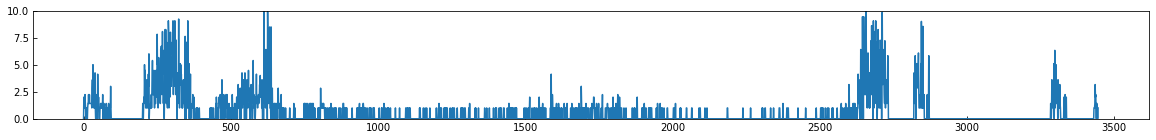

3207_001


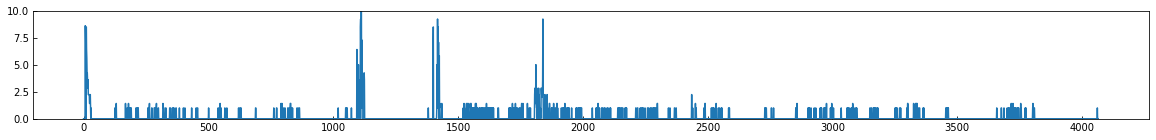

3209_001


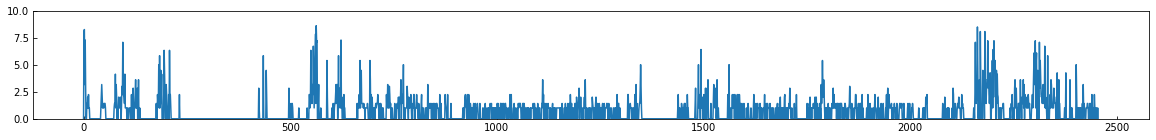

3218_001


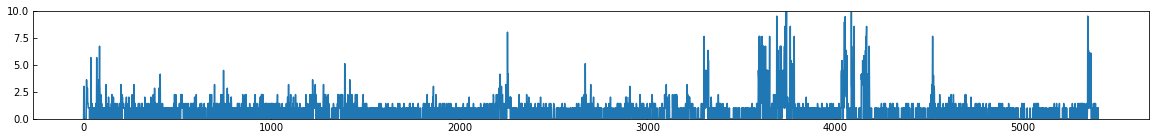

3218_002


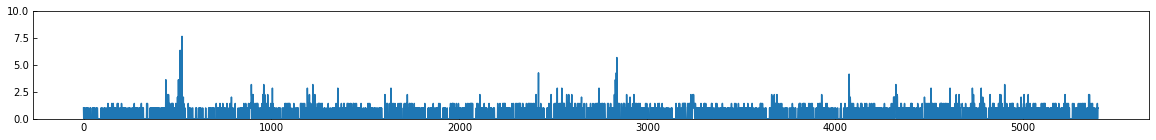

3218_003


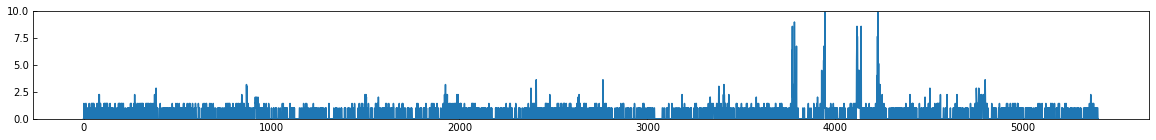

3218_004


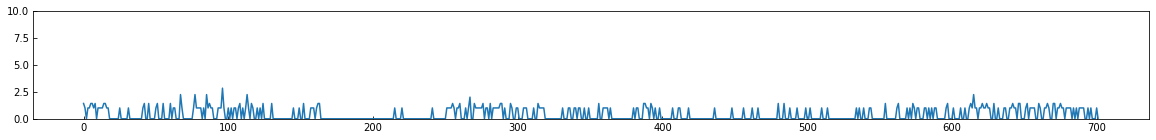

3225_003


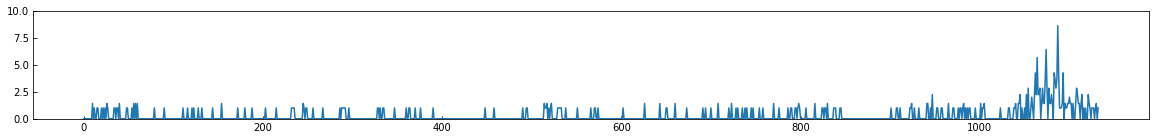

3241_001


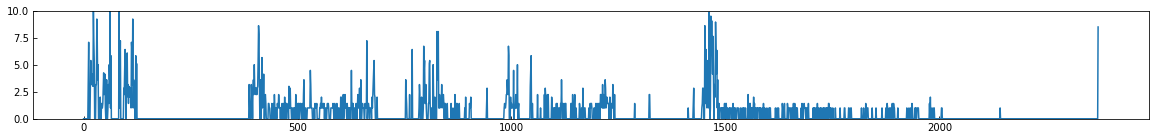

3249_001


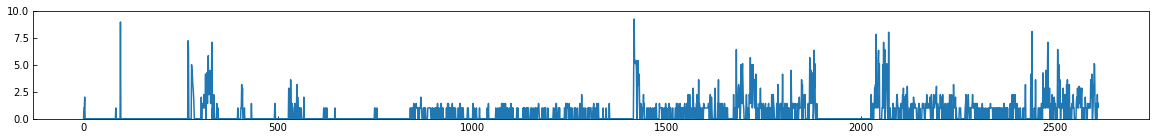

3257_001


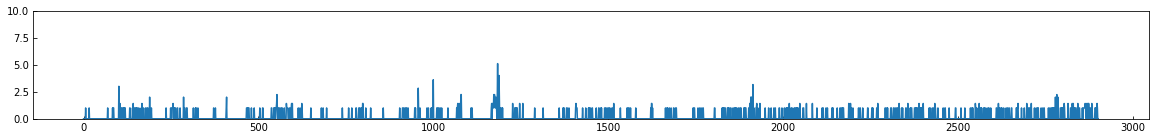

3264_001


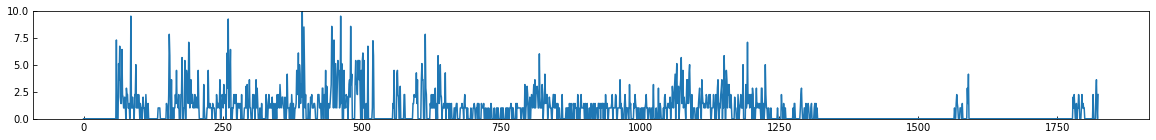

3274_001


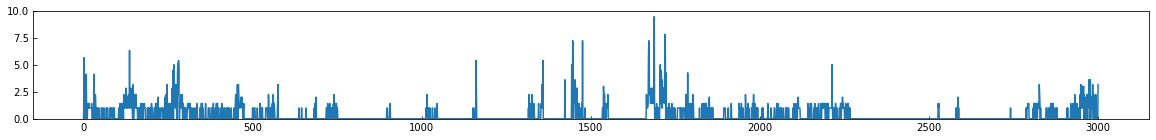

3290_002


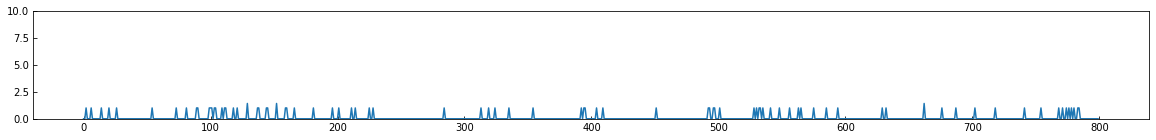

3292_001


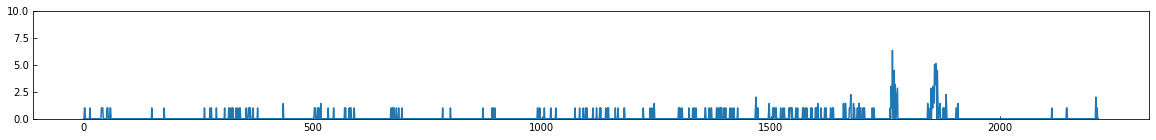

3303_001


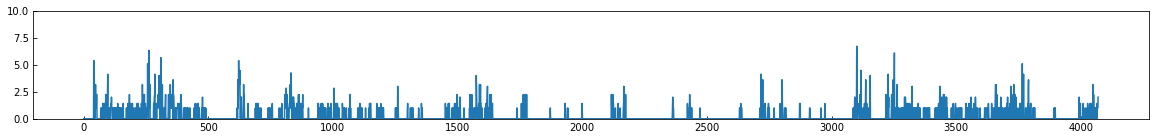

In [35]:
plot_movements(movements, labels[0])

3077_001


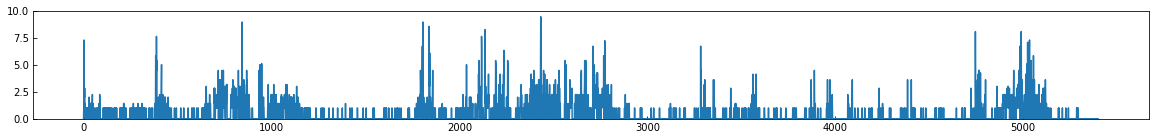

3077_002


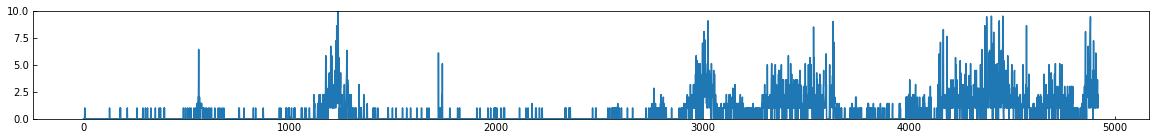

3087_001


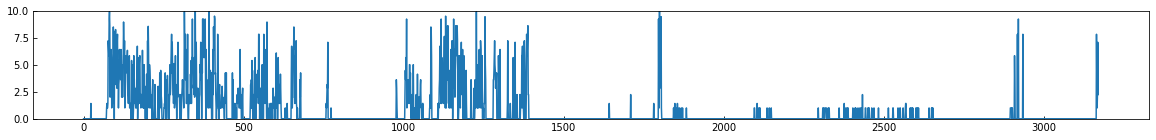

3092_001


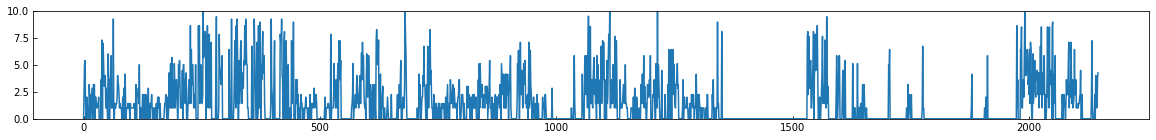

3101_001


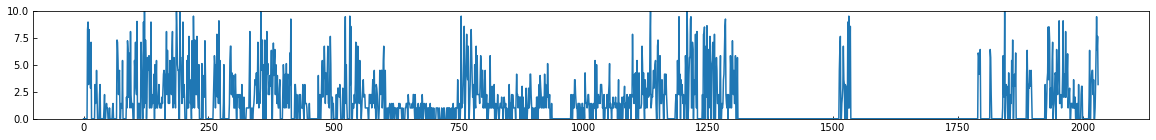

3109_002


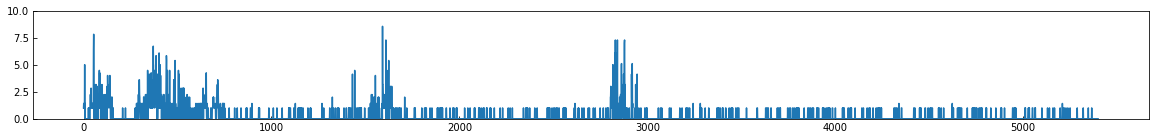

3109_003


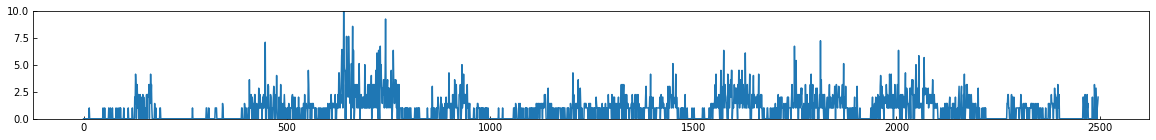

3156_001


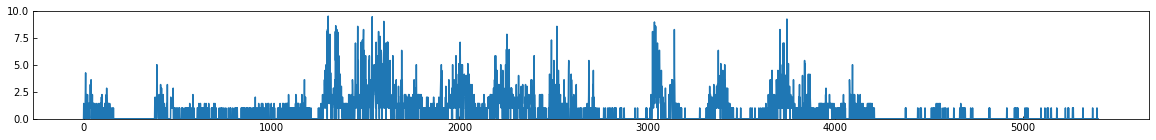

3156_002


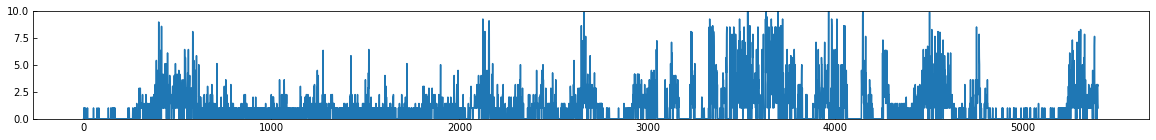

3156_003


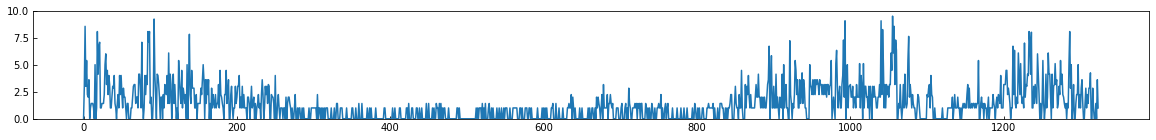

3225_001


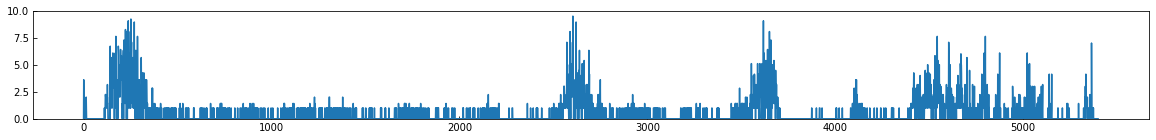

3225_002


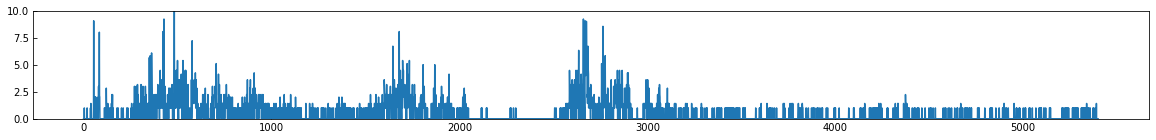

3290_001


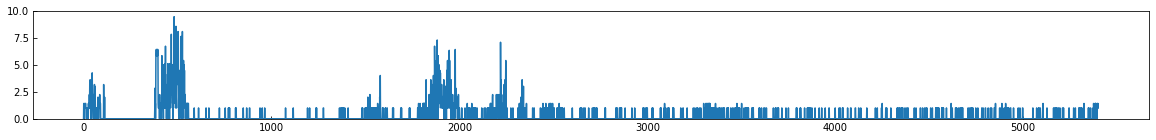

3302_001


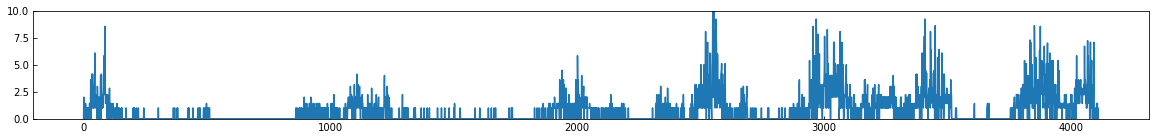

In [36]:
plot_movements(movements, labels[1])